In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Get all the helper functions from github

In [ ]:
import os
import re
import json

import pandas as pd

from fuzzywuzzy import fuzz
from pathlib import Path
# make sure you installed fuzzywuzzy and python-Levenshtein

class results():

    def __init__(self, filename = None):
        if not filename:
            filename = input('You did not pass in file name, please input your file name (please include .json as file extension)')
            while filename.search('\.(json)$', filename) == None:
                filename = input('Your input does not contain .json as file extension. Please input correct file name')

#         self.filepath = os.path.join(Path(__file__).parents[1], 'results', filename)
        self.filepath = os.path.join("/kaggle/working", filename)
        print(self.filepath)
        try:
            with open(self.filepath, 'x+') as results:
                print("File do not exist, creating file now")
                self.results = {
                    "experiment": []
                }
                self.df = pd.json_normalize(self.results, record_path=['experiment'], max_level=0)
        except FileExistsError:
            with open(self.filepath, 'r') as results:
                print("file exist, reading json")
                self.results = json.load(results)
                self.df = pd.json_normalize(self.results, record_path=['experiment'], max_level=0)
        

    def save(self, model = None, dataset = None, phase = None, results = None, additional = None, repeat = False):
        if model == None:
            return ValueError('Model name cannot be empty')
        if dataset == None:
            return ValueError('Dataset name cannot be empty')
        if phase == None:
            return ValueError('Phase name cannot be empty')
        if results == None:
            return ValueError('Results cannot be empty. If no results, please pass in \{\} instead')

        allLower = [f"{x['model'].lower()}_{x['dataset'].lower()}_{x['phase'].lower()}" for x in self.results['experiment']]

        if f'{model.lower()}_{dataset.lower()}_{phase.lower()}' not in allLower:
            res = {}
            res['model'] = model
            res['dataset'] = dataset
            res['phase'] = phase
            res['result'] = results
            if additional:
                res = {**res, **additional}

            temp_df = pd.DataFrame([res])
            self.df = pd.concat([self.df, temp_df])
        else:
            if repeat:
                self.df = self.df.drop(
                    self.df[
                        (self.df['model'] == model) &
                        (self.df['dataset'] == dataset) &
                        (self.df['phase'] == phase)
                    ].index
                )
                res = {}
                res['model'] = model
                res['dataset'] = dataset
                res['phase'] = phase
                res['result'] = results
                if additional:
                    res = {**res, **additional}

                temp_df = pd.DataFrame([res])
                self.df = pd.concat([self.df, temp_df])
                # print(f'Test {test} is already in record, proceed to override.')
            else:
                ans = input(f'Model {model} using dataset {dataset} and phase {phase} is already in record, would you like to override? (y/n)')
                while ans.lower() not in ['y', 'n', 'yes', 'no']:
                    ans = input(f'answer {ans} invalid, please choose (y/n)')
                if ans.lower() in ['y', 'yes']:
                    self.df = self.df.drop(
                        self.df[
                            (self.df['model'] == model) &
                            (self.df['dataset'] == dataset) &
                            (self.df['phase'] == phase)
                        ].index
                    )
                    res = {}
                    res['model'] = model
                    res['dataset'] = dataset
                    res['phase'] = phase
                    res['result'] = results
                    if additional:
                        res = {**res, **additional}

                    temp_df = pd.DataFrame([res])
                    self.df = pd.concat([self.df, temp_df])
                else:
                    print('Do not override, test result not saved')
                    return

        temp_result = self.df.to_json(orient="records")
        self.results['experiment'] = json.loads(temp_result)

        with open(self.filepath, 'w') as outfile:
            json.dump(self.results, outfile, indent=4)
            print('record saved')

    def checkIfTestExist(self, model = None, dataset = None, phase = None):
        if model == None:
            return ValueError('Model name cannot be empty')
        if dataset == None:
            return ValueError('Dataset name cannot be empty')
        if phase == None:
            return ValueError('Phase name cannot be empty')

        allLower = [f"{x['model'].lower()}\{x['dataset'].lower()}\{x['phase'].lower()}" for x in self.results['experiment']]
        search = f'{model.lower()}\{dataset.lower()}\{phase.lower()}'
        curTest = []
        for test in allLower:
            if fuzz.token_sort_ratio(test, search) >= 50:
                curTest.append((test, fuzz.token_sort_ratio(test, search)))
        
        curTest = sorted(curTest, key=lambda x: x[1], reverse=True)
        if len(curTest) == 0:
            print('Cannot find any similar test')
            return
        else:
            print('Found the following similar tests: ...')
            for t in curTest:
                temp = t[0].split('\\')
                print('-------------------------------')
                print(f'model: {temp[0]}')
                print(f'dataset: {temp[1]}')
                print(f'phase: {temp[2]}')

    
    def refresh(self, returnDict = True):
        with open(self.filepath) as results:
            self.results = json.load(results)
            self.df = pd.json_normalize(self.results, record_path=['experiment'], max_level=0)

        if returnDict:
            return self.results
        else:
            return self.df

    def unnestDataframeLevel(self, level = 0):
        return pd.json_normalize(self.results, record_path=['experiment'], max_level=level)

    def printExistingTests(self):
        if len(self.results['experiment']) == 0:
            print('There are currently no tests')
        else:
            for test in self.results['experiment']:
                print('-------------------------------')
                print(f'model: {test["model"]}')
                print(f'dataset: {test["dataset"]}')
                print(f'phase: {test["phase"]}')

    # def getExistingTests(self):
    #     if len(self.results.keys()) == 0:
    #         print('There are currently no tests')
    #     else:
    #         return [test for test in self.results]

    def getAllResults(self):
        if len(self.results.keys()) == 0:
            print('There are currently no tests')
        return self.results['experiment']

    def getDataframe(self):
        return self.df


    # def getResultRanked(self, metricName = None):
    #     if metricName == None:
    #         return ValueError('Metric name cannot be empty')

    #     s = []
    #     noRes = []

    #     if len(self.results.keys()) == 0:
    #         print('There are currently no tests')
    #         return

    #     for test in self.results:
    #         if metricName in self.results[test]['results']:
    #             metricVal = self.results[test]['results'][metricName]
    #             s.append((test, metricVal))
    #         else:
    #             metricVal = 'Record does not exist'
    #             noRes.append((test, metricVal))

    #     s = sorted(s, key=lambda x: x[1], reverse=True)
    #     noRes = sorted(noRes, key=lambda y: y[0].lower())

    #     return s + noRes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_sample_weight

def make_confusion_matrix(
    y_true,
    y_pred=None,  # optionally pass in precalculated y predictions
    model=None,  # optionally pass in a model (along with x) to autogenerate y_pred
    x=None,  # optionally pass in a feature set (along with model) to autogenerate y_pred
    normalize="true",  # parameter for the sklearn confusion matrix function specifying how to normalize the values
    sample_weight=None,  # optionally provide precalculated sample weights
    autoweight_sample=True,  # generate sample weights automatically before calculating matrix
    print_heatmap=True,  # print the heatmap for confusion matrix
    label_names=None,  # optionally provide an explicit list of label names for the heatmap
    label_encoder=None,  # a label encoder for the to automatically get the label names
    figsize=(9, 9),  # size of the heatmap displayed
    title=None,  # printed title of the heatmap
):

    # resolve polymorphisms / optional values
    y_pred = resolve_y_pred(y_pred=y_pred, model=model, x=x,)
    sample_weight = resolve_sample_weight(y_true, sample_weight, autoweight_sample)
    label_names = resolve_label_names(
        y_true,
        y_pred,
        model=model,
        label_names=label_names,
        label_encoder=label_encoder,
    )

    # calculate the confusion matrix
    cm = confusion_matrix(
        y_true=y_true, y_pred=y_pred, normalize=normalize, sample_weight=sample_weight,
    )

    # print a heatmap
    if print_heatmap:
        plt.figure(figsize=figsize, facecolor="white")
        sns.heatmap(
            cm,
            annot=True,
            fmt=".3f",
            linewidths=0.5,
            square=True,
            cmap="Blues_r",
            xticklabels=label_names,
            yticklabels=label_names,
        )
        plt.ylabel("Actual Label")
        plt.xlabel("Predicted Label")
        if title:
            plt.title(title)
        plt.show()

    # return the 2D confusion matrix array
    return cm


# reusable helper function to get a y_pred array from various polymorphisms
def resolve_y_pred(y_pred=None, model=None, x=None,postprocess_y_pred_fn=None):
    if y_pred is not None:
        return y_pred
    elif model and x is not None:
        y_pred = model.predict(x)
        if postprocess_y_pred_fn is not None:
            y_pred = postprocess_y_pred_fn(y_pred)
        return y_pred
    else:
        raise Exception(
            "Both a model and x (feature set) must be passed if a y_pred is not provided."
        )


# reusable helper function to get a label_names array from various polymorphisms
def resolve_label_names(
    y_true, y_pred, model=None, label_names=None, label_encoder=None,
):

    # if no label names are explicitly provided
    if not label_names:
        # get a unique list of labels in the matrix
        unique_labels = None
        if model and hasattr(model, 'classes_'):
            unique_labels = list(model.classes_)
        else:
            unique_labels = np.sort(np.unique(np.concatenate([y_true, y_pred])))
        if label_encoder:

            # convert label to friendly names if encoder is provided
            label_names = label_encoder.inverse_transform(unique_labels)
        else:
            # otherwise use the raw (usually integer) label values
            label_names = [str(l) for l in unique_labels]
    return label_names


# reusable helper function to get a sample_weight array from various polymorphisms
def resolve_sample_weight(
    y_true, sample_weight=None, autoweight_sample=None,
):
    # compute the weights for each class if not explicitly provided
    if not sample_weight and autoweight_sample:
        sample_weight = compute_sample_weight(class_weight="balanced", y=y_true)
    return sample_weight


def make_classification_report(
    # same params as sklearn.metrics.classification_report
    y_true,
    y_pred=None,  # optionally pass in precalculated y predictions
    model=None,  # optionally pass in a model (along with x) to autogenerate y_pred
    x=None,  # optionally pass in a feature set (along with model) to autogenerate y_pred
    labels=None,  # optionally pass a list of label (integers) to *only* include in the report
    target_names=None,  # optionally provide an explicit list of label names defining the label indexes
    label_encoder=None,  # optionally provide a label encoder for the to automatically get the label names
    save_result=False,
    model_name=None,
    dataset_name=None,
    phase=None,
    additional_result_param=None,
    repeat=False,
    sample_weight=None,
    result_filename=None,
    digits=2,
    output_dict=False,
    zero_division="warn",
    print_report=False,
    compare_to=None,
    postprocess_y_pred_fn=None,
):

    if save_result == True:
        if not model_name:
            raise ValueError("Missing model name")
        if not dataset_name:
            raise ValueError("Missing dataset name")
        if not phase:
            raise ValueError("Missing phase")

    # resolve polymorphisms / optional values
    y_pred = resolve_y_pred(y_pred=y_pred, model=model, x=x,postprocess_y_pred_fn=postprocess_y_pred_fn)
    target_names = resolve_label_names(
        y_true,
        y_pred,
        model=model,
        label_names=target_names,
        label_encoder=label_encoder,
    )

    cr = classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=target_names,
        sample_weight=sample_weight,
        digits=digits,
        output_dict=True,
        zero_division=zero_division,
    )

    # fix some bizarre parsing irregularity
    if type(cr["accuracy"]) != "dict":
        cr["accuracy"] = {
            "f1-score": cr["accuracy"],
            "support": cr["weighted avg"]["support"],
        }

    # generate mcc for each class
    for i in range(len(target_names)):
        cr[target_names[i]]["mcc"] = matthews_corrcoef(y_true == i, y_pred == i)

    # generate multiclass mcc
    cr["accuracy"]["mcc"] = matthews_corrcoef(y_true, y_pred)

    if save_result:
        save = results(result_filename)
        if additional_result_param:
            save.save(
                model=model_name,
                dataset=dataset_name,
                phase=phase,
                results=cr,
                additional=additional_result_param,
                repeat=repeat,
            )
        else:
            save.save(
                model=model_name,
                dataset=dataset_name,
                phase=phase, 
                results=cr, 
                repeat=repeat
            )

    metric_cols = ["label", "precision", "recall", "f1-score", "support", "mcc"]
    meta_labels = ["", "accuracy", "macro avg", "weighted avg", "min"]
    real_labels = [k for k in cr.keys() if k not in meta_labels]

    cr["min"] = {
        m: min([cr[g][m] for g in real_labels]) for m in metric_cols if m != "label"
    }

    # if another classification report is passed to compare to, calculate the delta for each value
    if compare_to is not None:
        for rk, rv in cr.copy().items():
            for mk, mv in rv.copy().items():
                cr[rk][mk] = mv - compare_to[rk][mk]

    # return dictionary as-is if requested and no string parsing is necessary for print
    deferred_cr = None
    if output_dict and print_report == False:
        return cr
    else:
        deferred_cr = cr.copy()

    # parse a table to a string

    # put in empty key to simulate newline been actual labels and metalabels
    cr[""] = {}

    # format all floats as strings
    cr_arr = [
        {
            "label": label,
            **{
                metric_key: (
                    "{:." + str(0 if metric_key == "support" else digits) + "f}"
                ).format(metric_value)
                for metric_key, metric_value in l_object.items()
            },
        }
        for label, l_object in cr.items()
    ]

    # split labels into real labels and meta labels for calculating sort order
    real_labels.sort()

    # sort all table rows
    cr_arr.sort(
        key=lambda x: real_labels.index(x["label"])
        if x["label"] in real_labels
        else len(real_labels) + meta_labels.index(x["label"])
    )

    # prepend header row and simulated newline
    cr_arr = [{c: c for c in metric_cols if c != "label"}, {}] + cr_arr

    # calculate padding necessary to align all rows
    paddings = {
        col: max([len(r.get(col, "")) for r in cr_arr]) + 2 for col in metric_cols
    }

    report_string = "\n".join(
        [
            "".join([r.get(c, "").rjust(paddings[c], " ") for c in metric_cols])
            for r in cr_arr
        ]
    )

    if print_report:
        print(report_string)

    return deferred_cr if output_dict else report_string

# Preprocess data

In [ ]:
pip install tensorflow

In [2]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [3]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd


# load base dataframe

filepath = "/kaggle/input/mtg-jamendo-genre-features-base/mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)
  
class_weight = compute_class_weight(class_weight='balanced', 
                                    classes=np.unique(y_train), 
                                    y=y_train)
class_weight = {idx: weight for idx, weight in enumerate(class_weight)}

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train: (17080, 2739)
X_test:  (4271, 2739)


In [4]:
# used source code from 
# https://github.com/tensorflow/addons/blob/v0.17.0/tensorflow_addons/metrics/matthews_correlation_coefficient.py#L26-L138

import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked


# @tf.keras.utils.register_keras_serializable(package="Addons")
class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    """Computes the Matthews Correlation Coefficient.
    The statistic is also known as the phi coefficient.
    The Matthews correlation coefficient (MCC) is used in
    machine learning as a measure of the quality of binary
    and multiclass classifications. It takes into account
    true and false positives and negatives and is generally
    regarded as a balanced measure which can be used even
    if the classes are of very different sizes. The correlation
    coefficient value of MCC is between -1 and +1. A
    coefficient of +1 represents a perfect prediction,
    0 an average random prediction and -1 an inverse
    prediction. The statistic is also known as
    the phi coefficient.
    MCC = (TP * TN) - (FP * FN) /
          ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
    Args:
        num_classes : Number of unique classes in the dataset.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.
    Usage:
    >>> y_true = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0]], dtype=np.float32)
    >>> y_pred = np.array([[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0]], dtype=np.float32)
    >>> metric = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    -0.33333334
    """

    @typechecked
    def __init__(
        self,
        num_classes: FloatTensorLike,
        name: str = "MatthewsCorrelationCoefficient",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        """Creates a Matthews Correlation Coefficient instance."""
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.conf_mtx = self.add_weight(
            "conf_mtx",
            shape=(self.num_classes, self.num_classes),
            initializer=tf.keras.initializers.zeros,
            dtype=self.dtype,
        )

    # TODO: sample_weights
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=self.dtype)
        y_pred = tf.cast(y_pred, dtype=self.dtype)
        
        y_pred = tf.math.argmax(y_pred, axis=1)
        y_pred = tf.squeeze(y_pred)
        y_pred = tf.cast(y_pred, tf.int32)
        y_pred = tf.one_hot(y_pred, self.num_classes)
        
        y_true = tf.squeeze(y_true)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, self.num_classes)

        new_conf_mtx = tf.math.confusion_matrix(
            labels=tf.argmax(y_true, 1),
            predictions=tf.argmax(y_pred, 1),
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=self.dtype,
        )

        self.conf_mtx.assign_add(new_conf_mtx)

    def result(self):

        true_sum = tf.reduce_sum(self.conf_mtx, axis=1)
        pred_sum = tf.reduce_sum(self.conf_mtx, axis=0)
        num_correct = tf.linalg.trace(self.conf_mtx)
        num_samples = tf.reduce_sum(pred_sum)

        # covariance true-pred
        cov_ytyp = num_correct * num_samples - tf.tensordot(true_sum, pred_sum, axes=1)
        # covariance pred-pred
        cov_ypyp = num_samples**2 - tf.tensordot(pred_sum, pred_sum, axes=1)
        # covariance true-true
        cov_ytyt = num_samples**2 - tf.tensordot(true_sum, true_sum, axes=1)

        mcc = cov_ytyp / tf.math.sqrt(cov_ytyt * cov_ypyp)

        if tf.math.is_nan(mcc):
            mcc = tf.constant(0, dtype=self.dtype)

        return mcc

    def get_config(self):
        """Returns the serializable config of the metric."""

        config = {
            "num_classes": self.num_classes,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        """Resets all of the metric state variables."""

        for v in self.variables:
            K.set_value(
                v,
                np.zeros((self.num_classes, self.num_classes), v.dtype.as_numpy_dtype),
            )
#         self.conf_mtx.assign(0)

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()

# Experiment 1: No hidden layer

2022-07-23 21:22:32.906958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 21:22:33.042213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 21:22:33.043185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 21:22:33.044989: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 10)                27400     
Total params: 27,400
Trainable params: 27,400
Non-trainable params: 0
_________________________________________________________________


2022-07-23 21:22:35.993630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
401/401 [==============================] - 4s 6ms/step - loss: 1.4017 - MatthewsCorrelationCoefficient: 0.4832 - val_loss: 1.5095 - val_MatthewsCorrelationCoefficient: 0.5247
Epoch 2/100
401/401 [==============================] - 2s 5ms/step - loss: 0.9010 - MatthewsCorrelationCoefficient: 0.6056 - val_loss: 1.3493 - val_MatthewsCorrelationCoefficient: 0.5807
Epoch 3/100
401/401 [==============================] - 2s 5ms/step - loss: 0.7519 - MatthewsCorrelationCoefficient: 0.6481 - val_loss: 1.3333 - val_MatthewsCorrelationCoefficient: 0.6014
Epoch 4/100
401/401 [==============================] - 2s 5ms/step - loss: 0.6611 - MatthewsCorrelationCoefficient: 0.6750 - val_loss: 1.2263 - val_MatthewsCorrelationCoefficient: 0.6394
Epoch 5/100
401/401 [==============================] - 2s 5ms/step - loss: 0.6114 - MatthewsCorrelationCoefficient: 0.6900 - val_loss: 1.2247 - val_MatthewsCorrelationCoefficient: 0.6222
Epoch 6/100
401/401 [==============================] - 2s 5ms/ste

[2.3471720218658447, 0.6324499845504761]

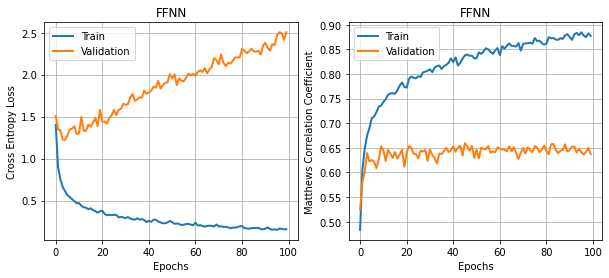

In [5]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(2739,))
output = tf.keras.layers.Dense(units=10)(input)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )



# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 2

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                175360    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 176,010
Trainable params: 176,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
401/401 [==============================] - 3s 6ms/step - loss: 1.4939 - MatthewsCorrelationCoefficient: 0.4649 - val_loss: 1.4809 - val_MatthewsCorrelationCoefficient: 0.5350
Epoch 2/100
401/401 [==============================] - 2s 5ms/step - loss: 0.8085 - MatthewsCorrelationCoefficient: 0.6318 - val_loss: 1.2310 - val_MatthewsCorrelationCoefficient: 0.6076
Epoch 3/100

[3.836146831512451, 0.6746232509613037]

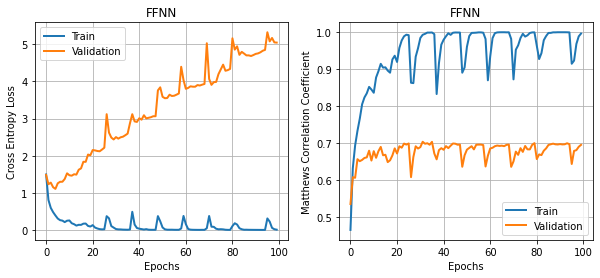

In [6]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(2739,))
layer = tf.keras.layers.Dense(units=64, activation="relu")(input)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )


# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 3

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                175360    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 176,010
Trainable params: 176,010
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
401/401 [==============================] - 3s 6ms/step - loss: 2.1721 - MatthewsCorrelationCoefficient: 0.3414 - val_loss: 1.6111 - val_MatthewsCorrelationCoefficient: 0.5079
Epoch 2/100
401/401 [==============================] - 2s 6ms/step

[1.708262324333191, 0.7022824287414551]

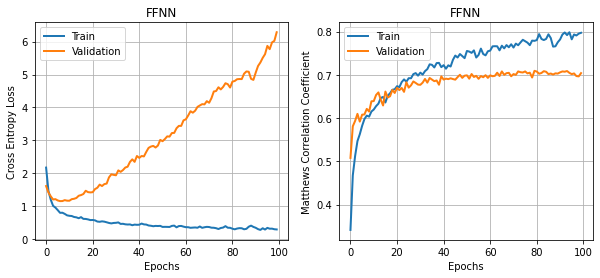

In [7]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(2739,))
layer = tf.keras.layers.Dense(units=64, activation="relu")(input)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )

# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 4

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                175360    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

[1.140409231185913, 0.6789104342460632]

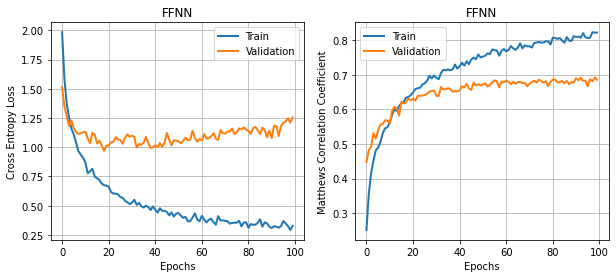

In [8]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

dropout_rate = 0.2
# build model
input = tf.keras.Input(shape=(2739,))
layer = input
# layer = tf.keras.layers.Dense(units=2048, activation="relu")(input)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=1024, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=516, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=256, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=128, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=64, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=32, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=16, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )

# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 5

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               350720    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

[1.6672898530960083, 0.6743996143341064]

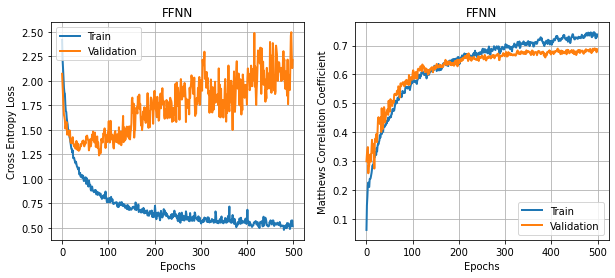

In [9]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

dropout_rate = 0.4
# build model
input = tf.keras.Input(shape=(2739,))
layer = input
# layer = tf.keras.layers.Dense(units=2048, activation="relu")(input)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=1024, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=516, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=256, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=128, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=64, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=32, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=16, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )

# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 6

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               350720    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

[1.8022359609603882, 0.6989675164222717]

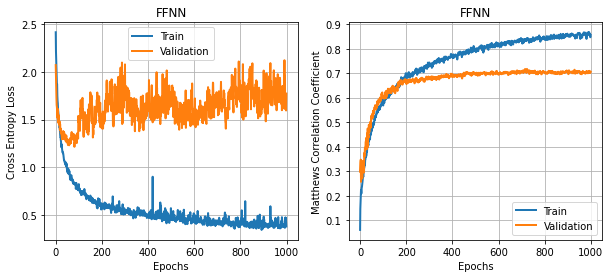

In [10]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

dropout_rate = 0.4
# build model
input = tf.keras.Input(shape=(2739,))
layer = input
# layer = tf.keras.layers.Dense(units=2048, activation="relu")(input)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=1024, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=516, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=256, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=128, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=64, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=32, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=16, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=1000, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )

# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 7

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2739)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               701440    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

[2.1626667976379395, 0.504236102104187]

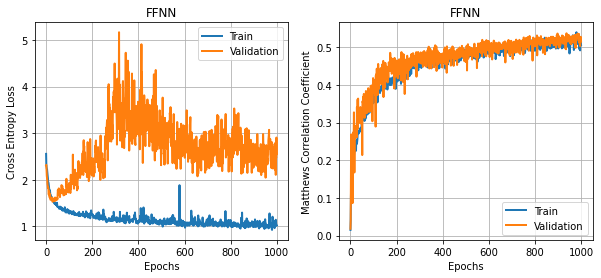

In [11]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

dropout_rate = 0.5
# build model
input = tf.keras.Input(shape=(2739,))
layer = input
# layer = tf.keras.layers.Dense(units=2048, activation="relu")(input)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=1024, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
# layer = tf.keras.layers.Dense(units=516, activation="relu")(layer)
# layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=256, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=128, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=64, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=32, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
layer = tf.keras.layers.Dense(units=16, activation="relu")(layer)
layer = tf.keras.layers.Dropout(dropout_rate)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=1000, 
#                     callbacks=[es],
                    class_weight=class_weight,
#                     validation_data=(X_valid,y_valid),
                    validation_split=0.25
                   )

# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("FFNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("FFNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)